# Risk Management: Calculate The Portfolio Drawdown & VaRs

### import a portfolio of daily stock returns & their portfolio weightings

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

StockReturns = pd.read_csv("C:/Users/Jenian/Documents/Research Library/Data Science/Python/StockReturns.csv", parse_dates=["Date"]).set_index("Date")
portfolio_weights = np.array([0.12, 0.15, 0.08, 0.05, 0.09, 0.10, 0.11, 0.14, 0.16])
StockReturns.head()

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
Date,,,,,,,,,
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811
2017-01-05,0.005085,0.000000,-0.014907,0.010462,-0.009205,0.030732,-0.005678,0.016682,-0.002806
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585
2017-01-10,0.001008,-0.000319,-0.012753,-0.001032,0.002901,-0.001280,-0.002861,-0.004404,0.000245


### calculate daily portfolio returns

In [45]:
port_ret = StockReturns.mul(portfolio_weights, axis =1)
StockReturns_p = StockReturns.copy()
StockReturns_p["Portfolio"] = port_ret.sum(axis = 1)

### calculate accumulated portfolio return

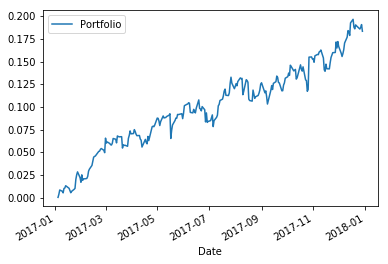

In [47]:
CumulativeReturns = ((1+StockReturns_p).cumprod() - 1)
CumulativeReturns[["Portfolio",]].plot()

### historical portfolio drawdown

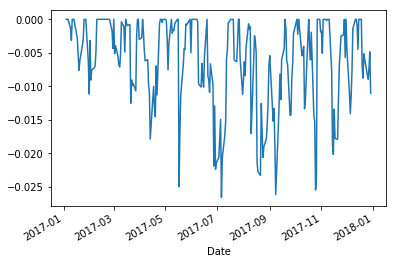

In [57]:
port_ret_base1 = 1+CumulativeReturns
running_max = np.maximum.accumulate(port_ret_base1)
running_max[running_max < 1] = 1
drawdown = (port_ret_base1)/running_max - 1
drawdown["Portfolio"].plot()
plt.show()

### create correlation matrix of positions and the portfolio

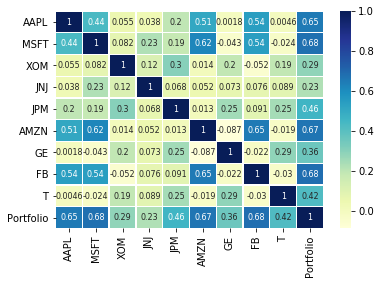

In [48]:
correlation_matrix = StockReturns_p.corr()
import seaborn as sns
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8})
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

### create covariance matrix

In [49]:
cov_mat = StockReturns.cov()
cov_mat_annual = cov_mat*252
cov_mat_annual.head()

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
AAPL,0.031119,0.011439,0.001088,0.000772,0.005687,0.018877,0.000062,0.016291,0.000138
MSFT,0.011439,0.021967,0.001357,0.003889,0.004536,0.019334,-0.001258,0.013656,-0.000599
XOM,0.001088,0.001357,0.012499,0.001521,0.005517,0.000333,0.004355,-0.000995,0.003682
JNJ,0.000772,0.003889,0.001521,0.013124,0.001267,0.001256,0.001661,0.001487,0.001733
JPM,0.005687,0.004536,0.005517,0.001267,0.026251,0.000448,0.008165,0.002496,0.006859


### calculate annual portfolio volatility

In [51]:
port_vol = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_mat_annual, portfolio_weights)))
print(port_vol)

0.0892188159806683


### calculate the sharpe ratio

In [55]:
rf = 0.023
port_return = ((1+StockReturns_p["Portfolio"].mean())**252)-1
port_sharpe = (port_return - rf)/port_vol
print(port_sharpe)

1.8678345093714694


### calculate historical VaR(95)

The minimum loss of the portfolio in the worst 5% cases is -0.889%


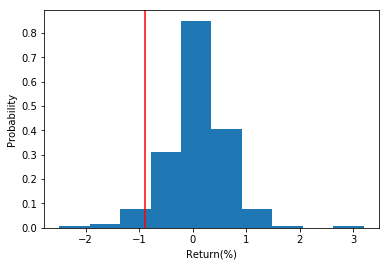

In [70]:
var_level = 95
StockReturns_perc = StockReturns_p*100
var_95 = np.percentile(StockReturns_perc["Portfolio"], 100 - var_level)
print('The minimum loss of the portfolio in the worst 5% cases is ' + str(round(var_95,3)) + '%')
sorted_rets = sorted(StockReturns_perc["Portfolio"])
plt.hist(sorted_rets, normed=True)
plt.axvline(x=var_95, color='r', linestyle='-', label='VaR 95: {0:.2f}%'.format(var_95))
plt.xlabel('Return(%)')
plt.ylabel('Probability')
plt.show()

### calculate historical CVaR(95)

In [88]:
cvar_95 = StockReturns_perc["Portfolio"][StockReturns_perc["Portfolio"] <= var_95].mean()
print('The average of all losses exceeding ',str(round(var_95,3)),'%',' is ', str(round(cvar_95,3)),'%')

The average of all losses exceeding  -0.889 %  is  -1.273 %


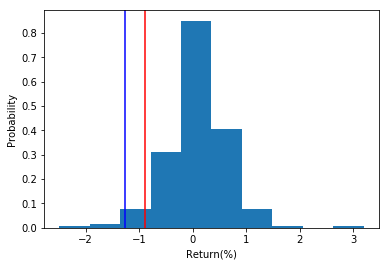

In [76]:
plt.hist(sorted_rets, normed=True)
plt.axvline(x=var_95, color='r', linestyle='-', label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=cvar_95, color='b', linestyle='-', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.xlabel('Return(%)')
plt.ylabel('Probability')
plt.show()

### calculate parametric VaR with normal distribution assumption

In [77]:
from scipy.stats import norm
mu = np.mean(StockReturns_p["Portfolio"])
std = np.std(StockReturns_p["Portfolio"])
confidence_level = 0.05
VaR = norm.ppf(confidence_level, mu, std)
print('Mean: ', str(mu), '\nVolatility: ', str(std), '\nVaR(95): ', str(var_95))

Mean:  0.000689347689 
Volatility:  0.00560900535013356 
VaR(95):  -0.88943378405


### scale the risk by time

Text(0,0.5,'Scaled VaR 95 (%)')

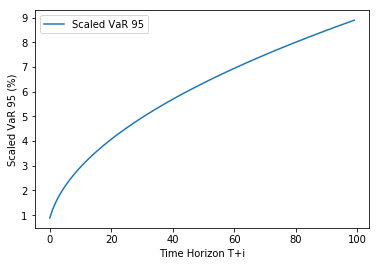

In [85]:
forecasted_values = np.empty([100, 2])
for i in range(100):
    forecasted_values[i, 0] = i
    forecasted_values[i, 1] = var_95*np.sqrt(i+1)
scale_var = pd.DataFrame(forecasted_values, columns = ['Time Horizon T+i', 'Scaled VaR 95'])
scale_var['Scaled VaR 95'] = scale_var['Scaled VaR 95']*-1
svar = scale_var.plot(x='Time Horizon T+i',y='Scaled VaR 95')
svar.set_ylabel('Scaled VaR 95 (%)')

In [ ]:
### monte carlo VaR(99)

In [87]:
sim_returns = []
for i in range(100):
    rand_rets = np.random.normal(mu, std, 252)
    sim_returns.append(rand_rets)
var_99 = np.percentile(sim_returns, 1)
print("Parametric VaR(99): ", round(100*var_99, 2),"%")

Parametric VaR(99):  -1.25 %
